In [9]:
import torch
import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
import random
from torch_geometric.datasets.graph_generator import GraphGenerator, BAGraph
from torch_geometric.utils import barabasi_albert_graph
from tqdm.notebook import tqdm

torch.manual_seed(7)
random.seed(7)

In [10]:
def combine_data_objects(data1, data2, random_connect = True):
    # Concatenate node features
    combined_x = torch.cat([data1.x, data2.x], dim=0)

    # Offset the edge indices of the second graph to account for the new nodes
    data2_offset_edge_index = data2.edge_index + data1.num_nodes

    # Concatenate edge indices
    combined_edge_index = torch.cat([data1.edge_index, data2_offset_edge_index], dim=1)

    # Concatenate edge attributes if available
    if data1.edge_attr is not None and data2.edge_attr is not None:
        combined_edge_attr = torch.cat([data1.edge_attr, data2.edge_attr], dim=0)
    else:
        combined_edge_attr = None

    # Link Graphs TODO: Connect a random subset or something
    if random_connect and data1.num_nodes > 0 and data2.num_nodes > 0:
        node1 = random.choice(range(data1.num_nodes))
        node2 = random.choice(range(data1.num_nodes)) + data1.num_nodes
        # print(combined_edge_index.shape, torch.Tensor([[node1, node2]]).shape)
        combined_edge_index = torch.cat([combined_edge_index, torch.Tensor([[node1, node2]]).T],axis=1)

    # Create the combined Data object
    combined_data = Data(x=combined_x, edge_index=combined_edge_index.to(torch.int64), edge_attr=combined_edge_attr)
        

    return combined_data

In [11]:
class MotifGenerator(GraphGenerator):
    def __init__(self, num_nodes, num_edges, node_feature_dim, motifs):
        self.num_nodes = num_nodes
        self.num_edges = num_edges
        self.node_feature_dim = 5

        self.motifs = motifs

        for motif in self.motifs:
            assert motif.num_nodes < self.num_nodes - 1
            assert motif.num_features <= node_feature_dim 

    def __call__(self, motif_index = None) -> Data:
        if motif_index is None: motif_index = random.choice(range(len(self.motifs)))
        motif_graph = self.motifs[motif_index]

        ba_graph = Data(num_nodes=self.num_nodes-motif_graph.num_nodes, edge_index=barabasi_albert_graph(self.num_nodes-motif_graph.num_nodes, self.num_edges))
        ba_graph.x = torch.eye(self.node_feature_dim)[torch.randint(low=0,high=self.node_feature_dim,size=(ba_graph.num_nodes,))]
        
        combined_graph = combine_data_objects(ba_graph, motif_graph)
        combined_graph.y = motif_index
        return combined_graph

In [12]:
motif_0 = Data(x=torch.Tensor([]), edge_index=torch.empty((2,0)))
motif_1 = Data(x=torch.eye(5), edge_index=dense_to_sparse(torch.ones((5,5))-torch.eye(5))[0])
motifs = [motif_0, motif_1]

g = MotifGenerator(num_nodes=10, num_edges=3, node_feature_dim=5, motifs=motifs)

In [13]:
data_list = [g(i % len(motifs)) for i in tqdm(range(1000))]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
import pickle
with open("data/OurMotifs/dataset.pkl", "wb") as f:
    pickle.dump(data_list, f)

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx

def visualize_graph(data):
    # Convert PyG Data object to networkx graph
    G = to_networkx(data)

    # Create a plot and customize its appearance
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw_networkx(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_size=8, font_weight='bold', font_color='black')

    if data.edge_attr is not None:
        edge_labels = {(u, v): data.edge_attr[idx].item() for idx, (u, v) in enumerate(data.edge_index.T)}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, font_color='red')

    plt.title(f"Graph Visualization: y={data.y}")
    plt.show()

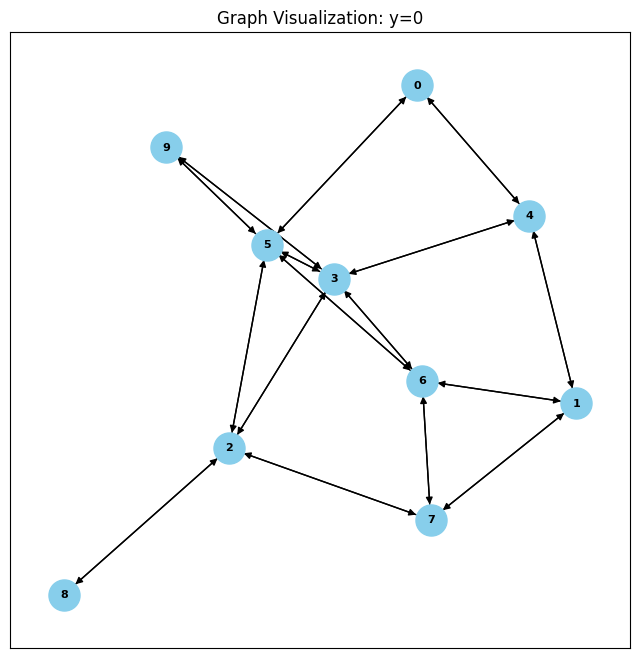

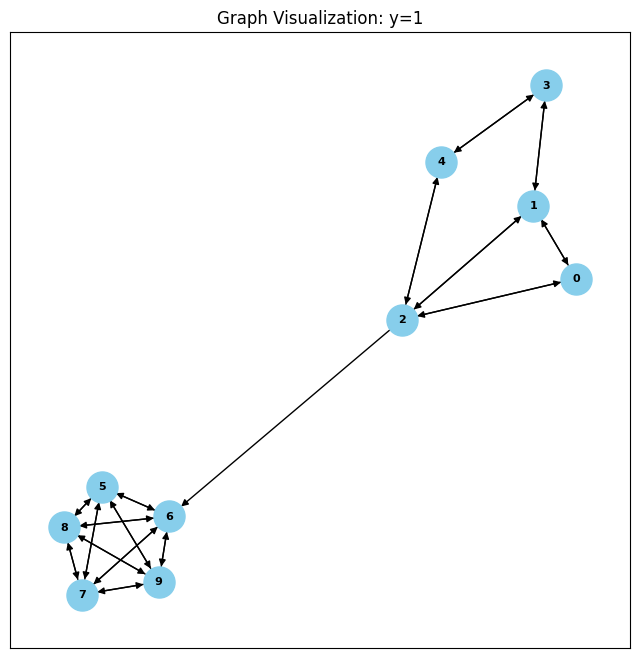

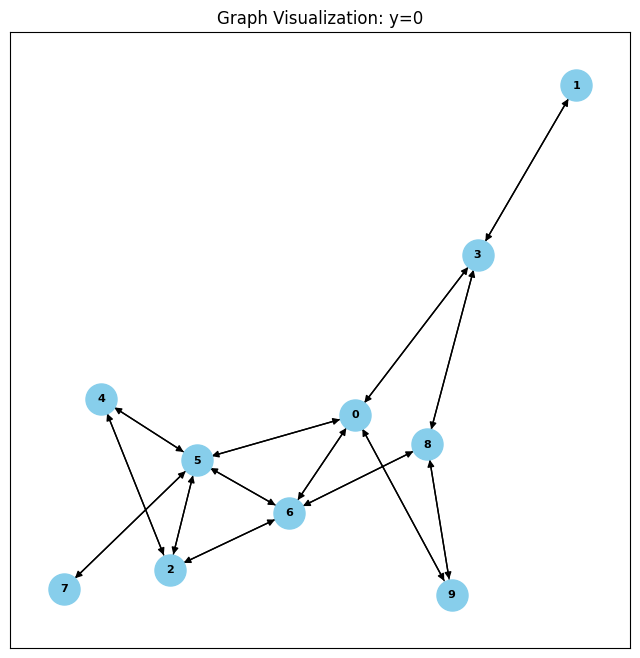

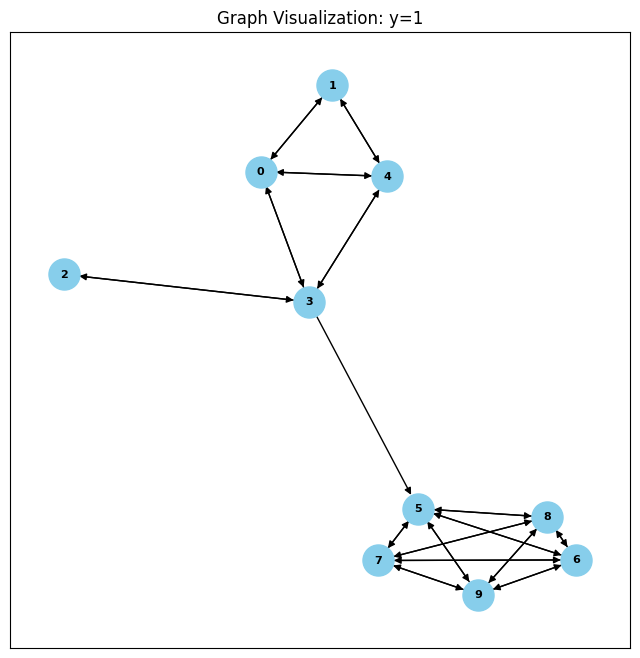

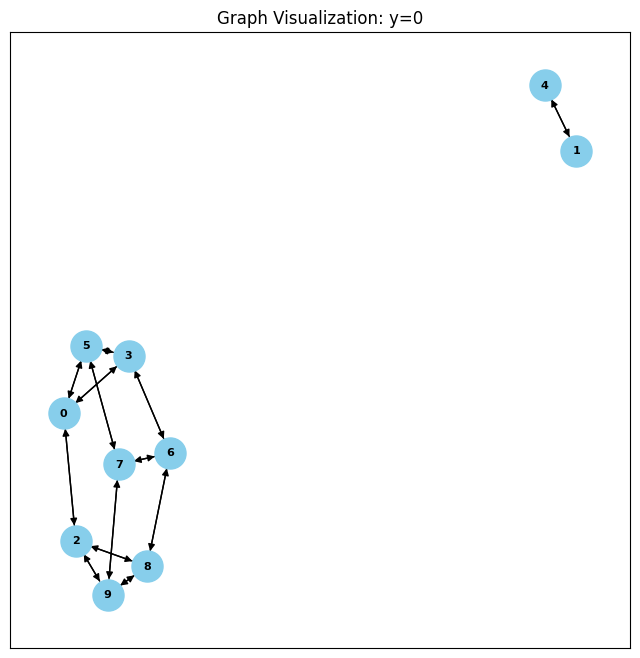

In [16]:
# random.shuffle(data_list)

for g in data_list[:5]:
    visualize_graph(g)